In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
proj = 'probabilistic_quicknat'
model = 'v2'
dataset = 'KORA'
report_id = '10_1571996796.7963011'
sample_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [4]:
sample_count_dict = {}
for r_id, sample in enumerate(sample_paths):
    print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

    split_str = sample.split('/')[-1].split('.')[0]
    v_id = split_str.split('_')[0]
    sample_id = split_str.split('_')[-1]
    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
        sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
    if sample_id == 'seg':
        sample_count_dict[v_id]['seg_spleen'] = counts[2]
        sample_count_dict[v_id]['seg_liver'] = counts[1]
    else:
        sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
        sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 12345, '1_spleen': 12332, '2_spleen': 12346, '3_spleen': 12372, '4_spleen': 12351, '5_spleen': 12365, '6_spleen': 12345, '7_spleen': 12350, '8_spleen': 12344, '9_spleen': 12349, '0_liver': 108869, '1_liver': 108887, '2_liver': 108847, '3_liver': 108869, '4_liver': 108839, '5_liver': 108837, '6_liver': 108869, '7_liver': 108838, '8_liver': 108881, '9_liver': 108862, 'seg_spleen': 108869, 'seg_liver': 12349}, 'KORA2459526': {'0_spleen': 19001, '1_spleen': 19027, '2_spleen': 19030, '3_spleen': 19023, '4_spleen': 19028, '5_spleen': 19022, '6_spleen': 19022, '7_spleen': 19019, '8_spleen': 19037, '9_spleen': 19014, '0_liver': 168987, '1_liver': 169150, '2_liver': 169028, '3_liver': 169040, '4_liver': 169000, '5_liver': 169000, '6_liver': 169021, '7_liver': 168992, '8_liver': 169044, '9_liver': 169026, 'seg_spleen': 169029, 'seg_liver': 19025}, 'KORA2455268': {'0_spleen': 7318, '1_spleen': 7325, '2_spleen': 7320, '3_spleen': 7335, '4_spleen': 

In [5]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv')

In [6]:
# df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
# df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
# df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [7]:
df_reports = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_report.csv')

In [8]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [9]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [10]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

In [11]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,coeff,p_value
age,0.008857,1.232938e-15
height,0.002735,8.371145e-14
sex,0.615385,4.480111e-14
weight,0.006076,5.552860e-17
smoker_former,0.514706,1.934475e-07
smoker_irregular,0.333333,2.394919e-01
smoker_non-smoker,0.423077,2.523419e-04
smoker_regular,0.500000,3.555895e-03
smoking-packages,0.014308,1.977551e-05
bmi-who_normal,0.190476,1.460153e-01


In [12]:

p_value_df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_p_values.csv', index_label='feats')
        

In [15]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [16]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,2366.154009,2.838688e-80
height,794.621157,4.193250e-106
sex,148257.967033,1.791579e-38
weight,1624.447842,7.019866e-126
smoker_former,139161.676471,5.780964e-21
smoker_irregular,131026.000000,4.531846e-03
smoker_non-smoker,132323.307692,1.103646e-13
smoker_regular,137033.000000,6.314401e-07
smoking-packages,4097.162459,1.591737e-15
bmi-who_normal,114211.214286,2.946265e-08


In [17]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,284.276365,9.092531e-58
height,95.910255,4.105613e-69
sex,18249.450549,6.200779e-35
weight,197.419914,1.221100e-77
smoker_former,17721.470588,2.968728e-21
smoker_irregular,16710.777778,4.250532e-03
smoker_non-smoker,15700.096154,6.285463e-12
smoker_regular,13976.125000,7.740313e-05
smoking-packages,502.673314,1.809721e-14
bmi-who_normal,12273.880952,3.563008e-06


In [40]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]

mod_s = []
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple1]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:

        for i in range(2):
            print(target)
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
seg_liver
['age', 'sex', 'diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'bmi-numeric']
------------------------------------------------------------
             df        sum_sq       mean_sq         F        PR(>F)
X           6.0  1.814977e+09  3.024962e+08  8.975193  2.366244e-08
Residual  147.0  4.954427e+09  3.370359e+07       NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           8.14e-09
Time:                        13:12:56   Log-Likelihood:                -1540.0
No. Observations:                 153   AIC:                             3092.
Df Residuals:                     147   BIC:                         

In [20]:
l = df_c.columns.values
l[29] = 'bmi_numeric'
df_c.columns = l
df_c.columns

Index(['Unnamed: 0', 'volume_id', '0_spleen', '1_spleen', '2_spleen',
       '3_spleen', '4_spleen', '5_spleen', '6_spleen', '7_spleen', '8_spleen',
       '9_spleen', '0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
       '5_liver', '6_liver', '7_liver', '8_liver', '9_liver', 'seg_spleen',
       'seg_liver', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'age', 'alcohol-g/day',
       'blood-pressure-diastolic', 'bmi_numeric', 'bmi-numeric', 'bmi-who',
       'cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total',
       'diabetes_status', 'hba1c-mmol/mol', 'hba1c-percentage', 'height',
       'hypertension', 'meds-antidiabetic', 'meds-antihypertensive',
       'meds-incretin-mimetics', 'meds-insulin-therapy',
       'meds-lipoprotein-lowering', 'meds-oral-antidiabetic',
       'mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter',
       'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein',
       'mrt-image-id', 'sex', 'smoker', 'smoking-packages', 'triglyceride',
       'wei

In [21]:
mod_liver = ols('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()
mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()

In [23]:

full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F    PR(>F)
age                  1.0  2.071324e+08  2.071324e+08   5.375996  0.021794
sex                  1.0  7.803402e+08  7.803402e+08  20.253258  0.000014
bmi_numeric          1.0  2.400239e+07  2.400239e+07   0.622968  0.431218
diabetes_status_0    1.0  8.377910e+07  8.377910e+07   2.174436  0.142459
diabetes_status_1    1.0  5.638822e+06  5.638822e+06   0.146352  0.702599
diabetes_status_2    1.0  5.056261e+06  5.056261e+06   0.131232  0.717678
Residual           147.0  5.663781e+09  3.852912e+07        NaN       NaN


In [24]:

full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F        PR(>F)
age                  1.0  8.425888e+09  8.425888e+09  14.946107  1.655789e-04
sex                  1.0  3.368086e+10  3.368086e+10  59.744180  1.562024e-12
bmi_numeric          1.0  1.519714e+10  1.519714e+10  26.957164  6.808865e-07
diabetes_status_0    1.0  1.054420e+10  1.054420e+10  18.703628  2.803301e-05
diabetes_status_1    1.0  1.546708e+09  1.546708e+09   2.743600  9.977755e-02
diabetes_status_2    1.0  2.189815e+08  2.189815e+08   0.388436  5.340882e-01
Residual           147.0  8.287145e+10  5.637513e+08        NaN           NaN


In [25]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

Text(0, 0.5, 'Dice Score')

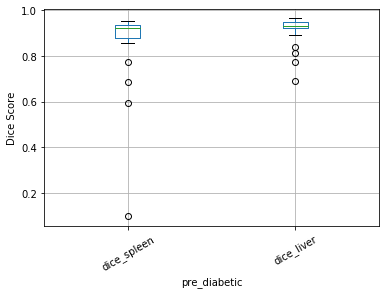

In [26]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

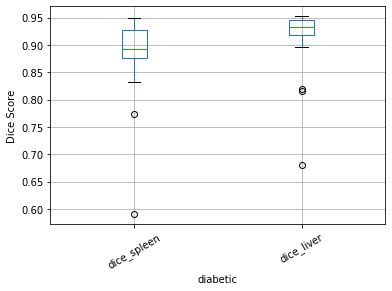

In [27]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

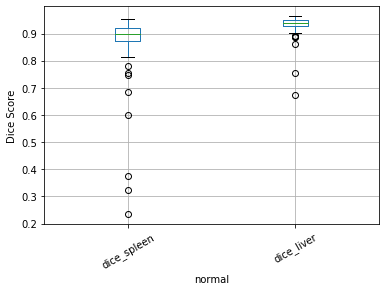

In [28]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

In [29]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


normal_dice_spleen vs pre_diabetic_dice_spleen
t: -0.09806645762744026
p: 0.9220282788900671


normal_dice_spleen vs diabetic_dice_spleen
t: -0.2944547649441329
p: 0.7689322142031613


pre_diabetic_dice_spleen vs diabetic_dice_spleen
t: -0.14361866159009803
p: 0.8863675846040839


normal_dice_liver vs pre_diabetic_dice_liver
t: 1.6101154195063971
p: 0.10976151788441496


normal_dice_liver vs diabetic_dice_liver
t: 2.099784776093241
p: 0.037896773492672904


pre_diabetic_dice_liver vs diabetic_dice_liver
t: 0.5094703217171279
p: 0.6126201179150637




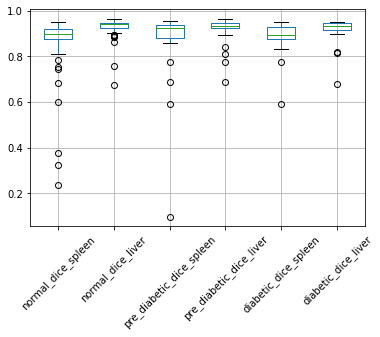

In [30]:
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'pre_diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs pre_diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('pre_diabetic_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'pre_diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs pre_diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('pre_diabetic_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_iou_spleen vs pre_diabetic_iou_spleen
t: 0.5533222347781995
p: 0.5809787458862572


normal_iou_spleen vs diabetic_iou_spleen
t: 0.07249114841334306
p: 0.9423348274908128


pre_diabetic_iou_spleen vs diabetic_iou_spleen
t: -0.24399878619368986
p: 0.8082106782837088


normal_iou_liver vs pre_diabetic_iou_liver
t: 2.1871855129466473
p: 0.030490491367953454


normal_iou_liver vs diabetic_iou_liver
t: 3.2169057302214594
p: 0.0016761651129769378


pre_diabetic_iou_liver vs diabetic_iou_liver
t: 0.2686442348812338
p: 0.7892872198567402




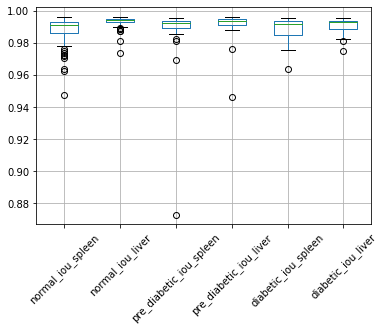

In [31]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'pre_diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs pre_diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('pre_diabetic_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'pre_diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs pre_diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('pre_diabetic_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen
t: -0.5149425863804127
p: 0.6074543584427001


normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.7029569865816151
p: 0.4834789379189326


pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.8135054927247016
p: 0.41971018151950434


normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver
t: 2.2627840270222195
p: 0.02528221777107286


normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: 2.7567017563253766
p: 0.006775403418375994


pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: 0.46363135820167417
p: 0.6448846083013136




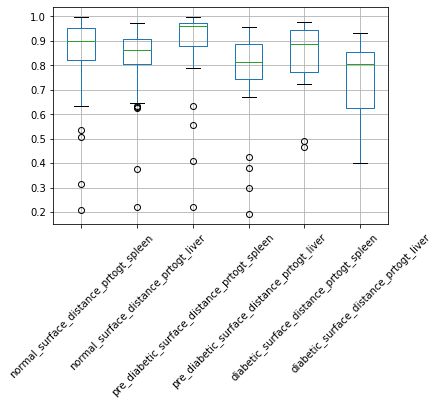

In [32]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen
t: 0.08586471719991862
p: 0.9317040641062238


normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: 0.12304872621664538
p: 0.9022796363301454


pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: 0.029625186218949447
p: 0.9764816080295727


normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver
t: 1.5030759779752865
p: 0.1352081538977348


normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: 1.1481134550593877
p: 0.2532637611258584


pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: -0.17280789579586012
p: 0.863486427591855




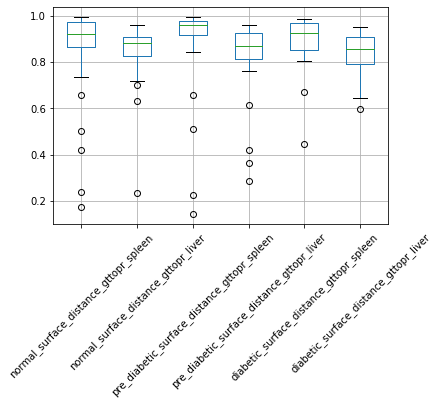

In [34]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: -0.2092288719515414
p: 0.8345921274932929


normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen
t: 0.4299905081432937
p: 0.6679934747017229


diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: -0.41534297002204024
p: 0.6796331440021033


normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: 1.968860334530517
p: 0.05106399412219373


normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver
t: 2.1355688106101822
p: 0.034799343781353125


diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: -0.17986952179558793
p: 0.8579677812961181




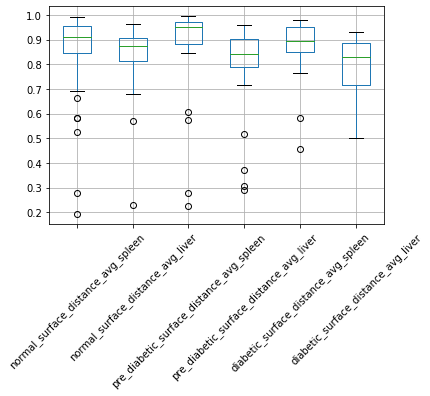

In [35]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)

print('normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_avg_spleen'].dropna().values)
print('normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)
print('diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')


normal_dice_mean vs pre_diabetic_dice_mean
t: 0.372167531497323
p: 0.7103649349157172


normal_dice_mean vs diabetic_dice_mean
t: 0.4263069345659325
p: 0.6706675084902767


diabetic_dice_mean vs pre_diabetic_dice_mean
t: -0.07007056265032613
p: 0.9444115349903739




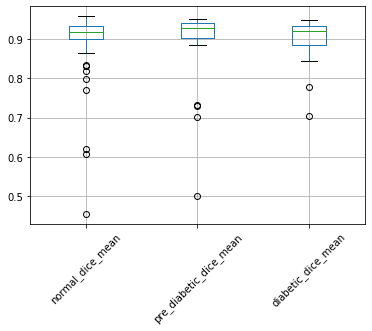

In [36]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values



t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)

print('normal_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)
print('normal_dice_mean vs diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)
print('diabetic_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')


normal_ged vs pre_diabetic_ged
t: -0.18880799750222677
p: 0.8505332861758439


diabetic_ged vs pre_diabetic_ged
t: 0.33267216194516713
p: 0.740745384969185


normal_ged vs diabetic_ged
t: -0.6246762019261488
p: 0.5333999046145028


normal_sncc vs pre_diabetic_sncc
t: -0.24647961327594153
p: 0.8056938746363362


normal_sncc vs diabetic_sncc
t: -1.5519424520069063
p: 0.12337684312319713


pre_diabetic_sncc vs diabetic_sncc
t: -1.160778318150403
p: 0.2511367201090421




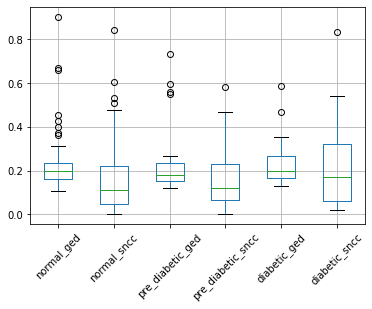

In [37]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)

print('normal_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)
print('diabetic_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'diabetic_ged'].dropna().values)
print('normal_ged vs diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'pre_diabetic_sncc'].dropna().values)
print('normal_sncc vs pre_diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('normal_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('pre_diabetic_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -3.400246465232793
p: 0.0008909550823485025


normal_seg_spleen vs diabetic_seg_spleen
t: -4.606366685254875
p: 1.0503819212029323e-05


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 1.510228409969395
p: 0.13715654033779742


normal_seg_liver vs pre_diabetic_seg_liver
t: -1.1642967137776528
p: 0.24640380442769677


normal_seg_liver vs diabetic_seg_liver
t: -1.5847755544887494
p: 0.11571657951182955


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.6861715505041576
p: 0.49571275498084033




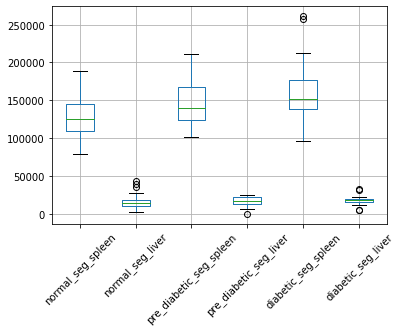

In [38]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

In [13]:
url = 'https://stats.idre.ucla.edu/stat/data/hsb2.csv'

hsb2 = pd.read_csv(url)


In [14]:
import patsy

In [22]:
patsy.dmatrices("write ~ C(race, Treatment(reference=2))", data=hsb2)

(DesignMatrix with shape (200, 1)
   write
      52
      59
      33
      44
      52
      52
      59
      46
      57
      55
      46
      65
      60
      63
      57
      49
      52
      57
      65
      39
      49
      63
      40
      52
      44
      37
      65
      57
      38
      44
   [170 rows omitted]
   Terms:
     'write' (column 0)
   (to view full data, use np.asarray(this_obj)),
 DesignMatrix with shape (200, 4)
   Columns:
     ['Intercept',
      'C(race, Treatment(reference=2))[T.1]',
      'C(race, Treatment(reference=2))[T.3]',
      'C(race, Treatment(reference=2))[T.4]']
   Terms:
     'Intercept' (column 0)
     'C(race, Treatment(reference=2))' (columns 1:4)
   (to view full data, use np.asarray(this_obj)))